pytorch层次结构可分为如下5层

> 参考：https://jackiexiao.github.io/eat_pytorch_in_20_days/3.%E5%B1%82%E6%AC%A1%E7%BB%93%E6%9E%84/

![2140.img](../pic/pt-level0.png)

下面以线性回归模型为例进行介绍

In [16]:
import torch 
torch.__version__

'1.11.0'

In [17]:
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)


In [18]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn


#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

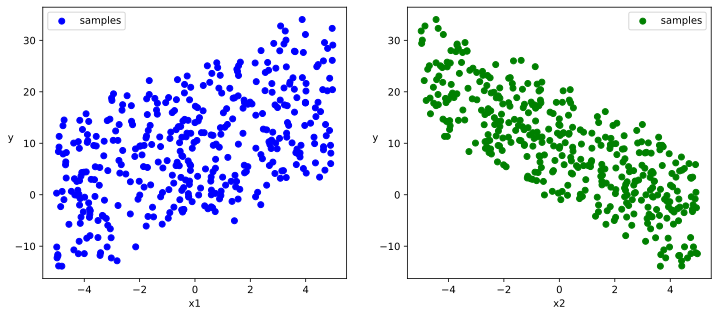

In [19]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

## 1. 低阶API--模型之🧱
![11.img](../pic/pt-level.png)

In [20]:
# 构建数据管道迭代器
batch_size = 8
def data_iter(features, labels, batch_size=batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)

# 测试数据管道效果   

(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[-3.0296,  3.4706],
        [ 0.5949,  3.2829],
        [ 3.6855,  2.2727],
        [ 2.7872, -2.3575],
        [-3.0594,  3.2917],
        [ 2.8885,  4.0601],
        [-4.0884, -0.7659],
        [-0.4760,  2.3862]])
tensor([[-8.3600],
        [ 0.8977],
        [ 8.8588],
        [19.9105],
        [-6.6231],
        [ 4.1323],
        [ 4.3190],
        [ 0.8476]])


In [21]:
"""
# 定义模型

注意，还可以利用nn.Module来组织模型变量。
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))
"""



class LinearRegression: 

    def __init__(self):
        self.w = torch.randn_like(w0,requires_grad=True)
        self.b = torch.zeros_like(b0,requires_grad=True)

    #正向传播
    def forward(self,x): 
        return x@self.w + self.b

    # 损失函数
    def loss_func(self,y_pred,y_true):  
        return torch.mean((y_pred - y_true)**2/2)

model = LinearRegression()

In [22]:
# 训练模型

def train_step(model, features, labels):

    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()

    # 使用torch.no_grad()避免梯度记录，也可以通过操作 model.w.data 实现避免梯度记录 
    with torch.no_grad():
        # 梯度下降法更新参数
        model.w -= 0.001*model.w.grad
        model.b -= 0.001*model.b.grad

        # 梯度清零
        model.w.grad.zero_()
        model.b.grad.zero_()
    return loss

In [23]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

tensor(164.8753, grad_fn=<MeanBackward0>)

In [24]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in data_iter(X,Y,batch_size):
            loss = train_step(model,features,labels)

        if epoch%200==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss.item())
            print("model.w =",model.w.data)
            print("model.b =",model.b.data)

train_model(model,epochs = 1000)


================================================================================2022-05-01 17:15:18
epoch = 200 loss =  1.303178071975708
model.w = tensor([[ 1.9715],
        [-2.9290]])
model.b = tensor([[10.0191]])

================================================================================2022-05-01 17:15:21
epoch = 400 loss =  1.3774349689483643
model.w = tensor([[ 1.9741],
        [-2.9262]])
model.b = tensor([[10.0228]])

================================================================================2022-05-01 17:15:24
epoch = 600 loss =  2.0368099212646484
model.w = tensor([[ 1.9740],
        [-2.9242]])
model.b = tensor([[10.0227]])

================================================================================2022-05-01 17:15:28
epoch = 800 loss =  1.862161636352539
model.w = tensor([[ 1.9743],
        [-2.9272]])
model.b = tensor([[10.0225]])

================================================================================2022-05-01 17:15:31
epoch = 1000 loss =  1.15

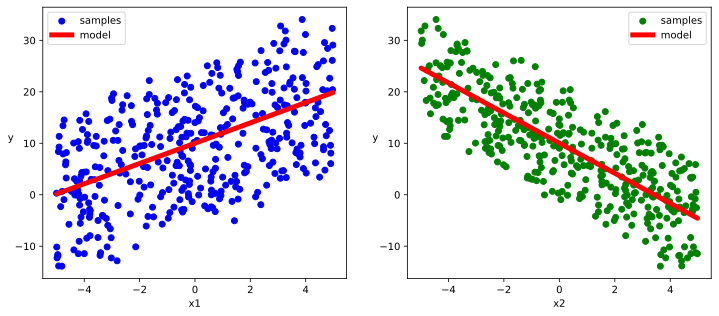

In [25]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].numpy(),Y[:,0].numpy(), c = "b",label = "samples")
ax1.plot(X[:,0].numpy(),(model.w[0].data*X[:,0]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].numpy(),Y[:,0].numpy(), c = "g",label = "samples")
ax2.plot(X[:,1].numpy(),(model.w[1].data*X[:,1]+model.b[0].data).numpy(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

## 2. 中阶API--模型之墙
Pytorch的中阶API主要包括各种模型层，损失函数，优化器，数据管道等等。
![2301](../pic/pt-middle_level.png)


In [42]:
from torch.utils.data import Dataset,DataLoader,TensorDataset

#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=0)

model = nn.Linear(2,1) #线性层
model.loss_func = nn.MSELoss() 
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.001)


def train_step(model, features, labels):
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in dl:
            loss = train_step(model,features,labels)
        if epoch%200==0:
            printbar()
            w = model.state_dict()["weight"]
            b = model.state_dict()["bias"]
            print("epoch =",epoch,"loss = ",loss)
            print("w =",w)
            print("b =",b)
train_model(model,epochs = 1000)


================================================================================2022-04-05 23:02:08
epoch = 200 loss =  5.706710338592529
w = tensor([[ 1.9806, -3.0185]])
b = tensor([10.2759])

================================================================================2022-04-05 23:02:14
epoch = 400 loss =  2.94909930229187
w = tensor([[ 1.9727, -3.0104]])
b = tensor([10.2749])

================================================================================2022-04-05 23:02:19
epoch = 600 loss =  3.525838851928711
w = tensor([[ 1.9739, -3.0180]])
b = tensor([10.2756])

================================================================================2022-04-05 23:02:25
epoch = 800 loss =  5.164609432220459
w = tensor([[ 1.9776, -3.0133]])
b = tensor([10.2762])

================================================================================2022-04-05 23:02:30
epoch = 1000 loss =  6.893721103668213
w = tensor([[ 1.9828, -3.0108]])
b = tensor([10.2755])


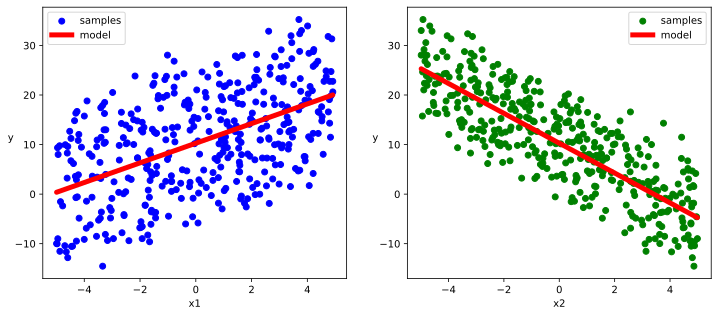

In [43]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.state_dict()["weight"],model.state_dict()["bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()